### COMP 473 Group Project

#### Facial Expression Recognition: 6-Class Classification

##### Import Libraries


In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

classes = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

#### Training Metrics Graph
Automatically update loss and accuracy of training and validation set and display the graph as the model gets trained

In [2]:
from IPython.display import clear_output


class PlotTrain(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        #To plot the graph
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)

        axs[i].legend()
        axs[i].grid()
        plt.tight_layout()
        plt.show()

### Sample image from each class

Training_47680332.jpg
Training_32689536.jpg
Training_35695824.jpg
Training_68738998.jpg
Training_8707760.jpg
Training_55773388.jpg
Training_72965838.jpg


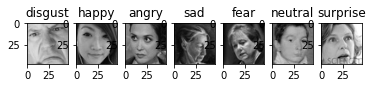

In [3]:
import random
import PIL

path_fer_2013_train = '../COMP_473_Project/FER_2013_DataSet/FER_2013/train'

for index, directory_name in enumerate(os.listdir(path_fer_2013_train)):
    joined_directory = os.path.join(path_fer_2013_train, directory_name)
    sample_image = random.choice(os.listdir(joined_directory))
    print(sample_image)
    image = PIL.Image.open(os.path.join(joined_directory, sample_image)).convert('I')
    plt.subplot(1, 7, index + 1)
    plt.title(directory_name)
    plt.imshow(image)

In [4]:
import pandas as pd


#load all the data
def get_all_file_paths(path):
    all_filenames = []
    for root, subdirs, files in os.walk(path):
        for name in files:
            absolute_filepath = os.path.join(root, name)
            relative_file_path = os.path.join(os.path.basename(root), name)
            all_filenames.append(relative_file_path)
            # print(name)
    return all_filenames


def get_label(file_name):
    if 'angry' in str(file_name):
        return 0
    if 'disgust' in str(file_name):
        return 1
    if 'fear' in str(file_name):
        return 2
    if 'happy' in str(file_name):
        return 3
    if 'neutral' in str(file_name):
        return 4
    if 'sad' in str(file_name):
        return 5
    if 'surprise' in str(file_name):
        return 6


categories = []

filenames = get_all_file_paths(path_fer_2013_train)
# use list() to show all the values inside a list
# print(list(filenames))
# randomize the files
random.shuffle(filenames)
for filename in filenames:
    categories.append(get_label(filename))
# print(list(categories))

# join the filename and categories list together

dataframe = pd.DataFrame({
    'filename': filenames,
    'category': categories
})



### Printing of datafram to show matching labels

In [5]:
random.shuffle(filenames)
print(dataframe.head())

                         filename  category
0   neutral/Training_41539110.jpg         4
1   disgust/Training_66604381.jpg         1
2  surprise/Training_75195753.jpg         6
3   surprise/Training_4546249.jpg         6
4       fear/Training_2717064.jpg         2


<AxesSubplot: >

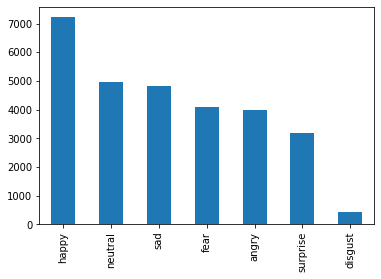

In [6]:
dataframe["category"] = dataframe["category"].replace(
    {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise', })
dataframe['category'].value_counts().plot.bar()

### Load the data

In [7]:
tf.keras.utils.image_dataset_from_directory??

In [21]:
# path_CK_Augmented = '..\COMP_473_Project\CK_Augmented'

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 3
color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

data_FER_train = tf.keras.utils.image_dataset_from_directory(
    path_fer_2013_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=20,
    color_mode=color_mode
)



Found 28709 files belonging to 7 classes.


In [22]:
data_iterator = data_FER_train.as_numpy_iterator()

In [23]:
batch = data_iterator.next()

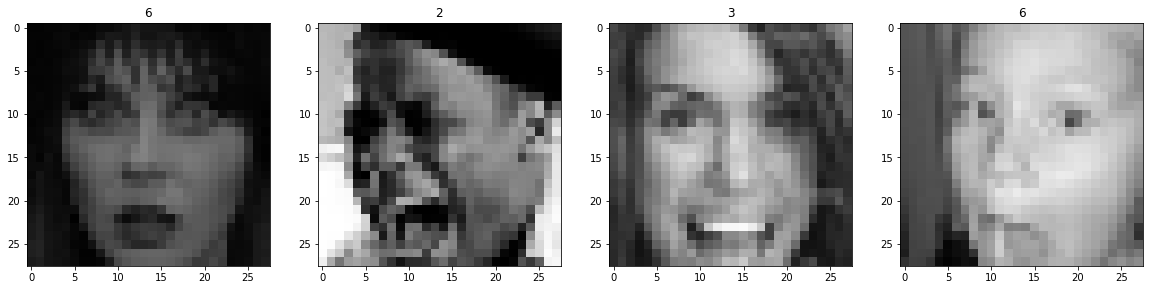

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Scale the data down


In [25]:
data_FER_train = data_FER_train.map(lambda x, y: (x / 255, y))

In [26]:
data_FER_train.as_numpy_iterator().next()

(array([[[[2.30112031e-01, 2.30112031e-01, 2.30112031e-01],
          [1.54901966e-01, 1.54901966e-01, 1.54901966e-01],
          [1.14005610e-01, 1.14005610e-01, 1.14005610e-01],
          ...,
          [8.84553865e-02, 8.84553865e-02, 8.84553865e-02],
          [1.03541449e-01, 1.03541449e-01, 1.03541449e-01],
          [9.89996046e-02, 9.89996046e-02, 9.89996046e-02]],
 
         [[1.90536216e-01, 1.90536216e-01, 1.90536216e-01],
          [1.55162066e-01, 1.55162066e-01, 1.55162066e-01],
          [1.14005610e-01, 1.14005610e-01, 1.14005610e-01],
          ...,
          [9.69187692e-02, 9.69187692e-02, 9.69187692e-02],
          [8.31332207e-02, 8.31332207e-02, 8.31332207e-02],
          [1.12745076e-01, 1.12745076e-01, 1.12745076e-01]],
 
         [[1.94597840e-01, 1.94597840e-01, 1.94597840e-01],
          [1.58543423e-01, 1.58543423e-01, 1.58543423e-01],
          [1.14005610e-01, 1.14005610e-01, 1.14005610e-01],
          ...,
          [8.10324028e-02, 8.10324028e-02, 8.1032

### Splitting the data

In [27]:
# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
# train_size = int(len(data_FER_train) * .80)
# test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
train_size = int(len(data_FER_train) * .80)
val_size = int(len(data_FER_train) * .20)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
# print('test_size: {}'.format(test_size))

train_size: 1148
val_size: 287


In [28]:
train = data_FER_train.take(train_size)
val = data_FER_train.skip(train_size).take(val_size)
# test_m1_t1 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

In [29]:
print(train)
print(val)
# print(test_m1_t1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [30]:
# tf.keras.Sequential??

##### Basic Model
No Pre-Processing Applied

<br>Model1_t1: Trained with Dataset 1

In [31]:
model1_t1 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    # tf.keras.layers.Conv2D(32, (1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    # tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems. 
    # If you add up the probability of each class we get 1. 
    tf.keras.layers.Dense(7, activation="softmax")
])
model1_t1.build()
# prints summary of our model.
model1_t1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          100416    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

Compile and Fit(train) the basic models

<br> Model1_t1

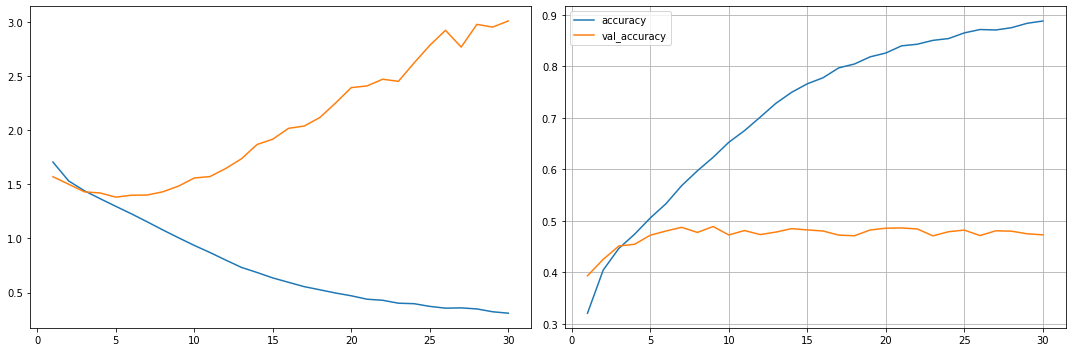

1148/1148 [==============================] - 9s 8ms/step - loss: 0.3103 - accuracy: 0.8878 - val_loss: 3.0079 - val_accuracy: 0.4726


In [32]:
# compile and fit the model1_t1
callback_list = [PlotTrain()]
model1_t1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model1_t1.fit(train, validation_data=val, epochs=30, callbacks=callback_list)

model1_t1.save("model1_t1_FER_2013.h5")

### Run 2 FER_2013 10 Epochs

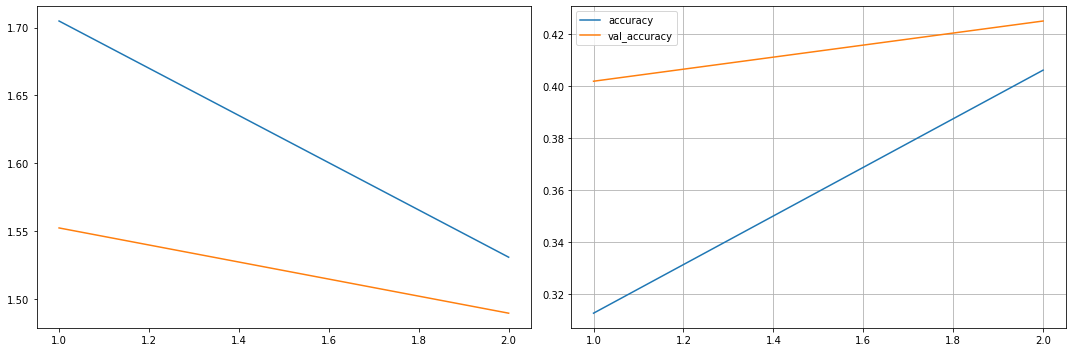

1148/1148 [==============================] - 9s 7ms/step - loss: 1.5309 - accuracy: 0.4062 - val_loss: 1.4896 - val_accuracy: 0.4251
Epoch 3/15
 420/1148 [=========>....................] - ETA: 4s - loss: 1.4629 - accuracy: 0.4269

In [ ]:
path_fer_2013_train = '../COMP_473_Project/FER_2013_DataSet/FER_2013/train'
path = path_fer_2013_train

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 20
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "model1_t2_FER_2013.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

data_FER_train = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_FER_train = data_FER_train.map(lambda x, y: (x / 255, y))

# We then split the training data 80% for training and 20% for validation
train_size = int(len(data_FER_train) * .80)
val_size = int(len(data_FER_train) * .20)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))

train = data_FER_train.take(train_size)
val = data_FER_train.skip(train_size).take(val_size)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(7, activation="softmax")
])
model.build()
# prints summary of our model.
model.summary()


model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

# monitor	Quantity to be monitored.
# patience	Number of epochs with no improvement after which training will be stopped.
# verbose	Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
# mode	One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

### Augmented Image cropping model for parameters

In [20]:
path_CK_Augmented_ImageCrop = '..\COMP_473_Project\CK_Augmented_ImageCrop'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m2_t1 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model2_t1 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model2_t1.build()
# prints summary of our model.
model2_t1.summary()

# compile and fit the model2_t1
callback_list = [PlotTrain()]

model2_t1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2_t1.fit(train, validation_data=val, epochs=30, callbacks=callback_list)

model2_t1.save("model2_t1.h5")


NameError: name 'path_CK_Augmented' is not defined

### Augmented Intensity Normalization model for parameters


In [ ]:
path_CK_Augmented_IntensityNormalization = '..\COMP_473_Project\CK_Augmented_IntensityNormalization'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m3_t1 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model3_t1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])

model3_t1.build()
# prints summary of our model.
model3_t1.summary()

# compile and fit the model3_t1
callback_list = [PlotTrain()]

model3_t1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model3_t1.fit(train, validation_data=val, epochs=30, callbacks=callback_list)

model3_t1.save("model3_t1.h5")

## 10 Epoch runs:

In [ ]:
epoch_number = 10

In [ ]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    labels='inferred',
    label_mode='categorical'
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m1_t2 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model1_t2 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model1_t2.build()
# prints summary of our model.
model1_t2.summary()
#
# # compile and fit the model1_t2
# callback_list = [PlotTrain()]
#
# model1_t2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
# model1_t2.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)
#
# model1_t2.save("model1_t2.h5")

# test_dir = 'pathToTestData'

#Fetch testing data from the dataset 1
# test_dir1 = 'D:\Concordia\COMP473\COMP_473_Project\TestSet1-new'
# test_generator1 = tf.keras.preprocessing.image.ImageDataGenerator()
# test_ds1 = test_generator1.flow_from_directory(test_dir1, target_size=(48, 48), batch_size=20, shuffle=False)

#storing actual class associated with each input image with the correct string label
# y_true1 = test_m1_t2.class_names
y_true1 = np.concatenate([y for x, y in test_m1_t2], axis=0)
print(y_true1[0])
true_class1 = []
for i in y_true1:
    # if (i == '1. 0. 0. 0. 0. 0.'):
    #     true_class1 += ['anger']
    # if (i == '0. 1. 0. 0. 0. 0.'):
    #     true_class1 += ['disgust']
    # if (i == '0. 0. 1. 0. 0. 0.'):
    #     true_class1 += ['fear']
    # if (i == '0. 0. 0. 1. 0. 0.'):
    #     true_class1 += ['happy']
    # if (i == '0. 0. 0. 0. 1. 0.'):
    #     true_class1 += ['sadness']
    # if (i == '0. 0. 0. 0. 0. 1.'):
    #     true_class1 += ['surprise']
    if (i[0] == 1):
        true_class1 += ['anger']
    if (i[1] == 1):
        true_class1 += ['disgust']
    if (i[2] == 1):
        true_class1 += ['fear']
    if (i[3] == 1):
        true_class1 += ['happiness']
    if (i[4] == 1):
        true_class1 += ['sadness']
    if (i[5] == 1):
        true_class1 += ['surprise']

# #predict the category with the input images from the test set
model1_t2.load_weights('model1_t2.h5')
y_predict1 = model1_t2.predict(test_m1_t2)
classes_x1 = np.argmax(y_predict1, axis=1)

#change the class labels to string
predicted_class1 = []
for i in classes_x1:
    if (i == 0):
        predicted_class1 += ['anger']
    if (i == 1):
        predicted_class1 += ['disgust']
    if (i == 2):
        predicted_class1 += ['fear']
    if (i == 3):
        predicted_class1 += ['happiness']
    if (i == 4):
        predicted_class1 += ['sadness']
    if (i == 5):
        predicted_class1 += ['surprise']

print(classification_report(true_class1, predicted_class1))

# predictions = np.array([])
# labels =  np.array([])
# for x, y in test_m1_t2:
#   predictions = np.concatenate([predictions, model1_t2.predict(x)])
#   labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

# tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

cf_model1 = confusion_matrix(true_class1, predicted_class1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model1, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented_ImageCrop'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m2_t2 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model2_t2 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model2_t2.build()
# prints summary of our model.
model2_t2.summary()

# # compile and fit the model2_t2
# callback_list = [PlotTrain()]

# model2_t2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
# model2_t2.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)

# model2_t2.save("model2_t2.h5")


# # compile and fit the model1_t2
# callback_list = [PlotTrain()]
#
# model1_t2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
# model1_t2.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)
#
# model1_t2.save("model1_t2.h5")

# test_dir = 'pathToTestData'

#Fetch testing data from the dataset 1
# test_dir1 = 'D:\Concordia\COMP473\COMP_473_Project\TestSet1-new'
# test_generator1 = tf.keras.preprocessing.image.ImageDataGenerator()
# test_ds1 = test_generator1.flow_from_directory(test_dir1, target_size=(48, 48), batch_size=20, shuffle=False)

#storing actual class associated with each input image with the correct string label
# y_true1 = test_m1_t2.class_names
y_true1 = np.concatenate([y for x, y in test_m2_t2], axis=0)
print(y_true1[0])
true_class1 = []
for i in y_true1:
    if (i == 0):
        true_class1 += ['anger']
    if (i == 1):
        true_class1 += ['disgust']
    if (i == 2):
        true_class1 += ['fear']
    if (i == 3):
        true_class1 += ['happy']
    if (i == 4):
        true_class1 += ['sadness']
    if (i == 5):
        true_class1 += ['surprise']

# #predict the category with the input images from the test set
model2_t2.load_weights('model2_t2.h5')
y_predict1 = model2_t2.predict(test_m2_t2)
classes_x1 = np.argmax(y_predict1, axis=1)

#change the class labels to string
predicted_class1 = []
for i in classes_x1:
    if (i == 0):
        predicted_class1 += ['anger']
    if (i == 1):
        predicted_class1 += ['disgust']
    if (i == 2):
        predicted_class1 += ['fear']
    if (i == 3):
        predicted_class1 += ['happy']
    if (i == 4):
        predicted_class1 += ['sadness']
    if (i == 5):
        predicted_class1 += ['surprise']

print(classification_report(true_class1, predicted_class1))

# predictions = np.array([])
# labels =  np.array([])
# for x, y in test_m1_t2:
#   predictions = np.concatenate([predictions, model1_t2.predict(x)])
#   labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

# tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

cf_model2 = confusion_matrix(true_class1, predicted_class1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model2, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Image Cropping Training and Testing


In [ ]:
#Dataset 1
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented_ImageCrop2'

data_CK_Augmented1 = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train1_size = int(len(data_CK_Augmented1) * .56)
test1_size = int(len(data_CK_Augmented1) * .3)

# We then split the training data 80% for training and 20% for validation
val1_size = int(len(data_CK_Augmented1) * .14)
print('train_size: {}'.format(train1_size))
print('val_size: {}'.format(val1_size))
print('test_size: {}'.format(test1_size))

train1 = data_CK_Augmented1.take(train1_size)
val1 = data_CK_Augmented1.skip(train1_size).take(val1_size)
test_crop_1 = data_CK_Augmented1.skip(train1_size + val_size).take(test1_size)

#Dataset 2
data_CK_Augmented2 = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train2_size = int(len(data_CK_Augmented2) * .56)
test2_size = int(len(data_CK_Augmented2) * .3)

# We then split the training data 80% for training and 20% for validation
val2_size = int(len(data_CK_Augmented2) * .14)
print('train_size: {}'.format(train2_size))
print('val_size: {}'.format(val2_size))
print('test_size: {}'.format(test2_size))

train2 = data_CK_Augmented2.take(train2_size)
val2 = data_CK_Augmented2.skip(train2_size).take(val2_size)
test_crop_2 = data_CK_Augmented1.skip(train2_size + val2_size).take(test2_size)

#Dataset 3
data_CK_Augmented3 = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train3_size = int(len(data_CK_Augmented3) * .56)
test3_size = int(len(data_CK_Augmented3) * .3)

# We then split the training data 80% for training and 20% for validation
val3_size = int(len(data_CK_Augmented3) * .14)
print('train_size: {}'.format(train3_size))
print('val_size: {}'.format(val3_size))
print('test_size: {}'.format(test3_size))

train3 = data_CK_Augmented3.take(train3_size)
val3 = data_CK_Augmented2.skip(train3_size).take(val3_size)
test_crop_3 = data_CK_Augmented1.skip(train3_size + val3_size).take(test3_size)

In [ ]:
model_crop_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])

# prints summary of our model.
model_crop_1.summary()

# compile and fit the model3_t2
callback_list = [PlotTrain()]

model_crop_1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model_crop_1.fit(train1, validation_data=val1, epochs=epoch_number, callbacks=callback_list)
model_crop_1.save("model_inten_1.h5")

y_true1 = np.concatenate([y for x, y in test_crop_1], axis=0)
true_class1 = []
for i in y_true1:
    if (i == 0):
        true_class1 += ['anger']
    if (i == 1):
        true_class1 += ['disgust']
    if (i == 2):
        true_class1 += ['fear']
    if (i == 3):
        true_class1 += ['happiness']
    if (i == 4):
        true_class1 += ['sadness']
    if (i == 5):
        true_class1 += ['surprise']

# #predict the category with the input images from the test set
y_predict1 = model_crop_1.predict(test_crop_1)
classes_x1 = np.argmax(y_predict1, axis=1)

#change the class labels to string
predicted_class1 = []
for i in classes_x1:
    if (i == 0):
        predicted_class1 += ['anger']
    if (i == 1):
        predicted_class1 += ['disgust']
    if (i == 2):
        predicted_class1 += ['fear']
    if (i == 3):
        predicted_class1 += ['happiness']
    if (i == 4):
        predicted_class1 += ['sadness']
    if (i == 5):
        predicted_class1 += ['surprise']

print(classification_report(true_class1, predicted_class1))
cf_model3 = confusion_matrix(true_class1, predicted_class1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model3, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## THE CORRECT CODE

In [ ]:
# get training and validation data on dataset 3
train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    'D:\Concordia\COMP473\COMP_473_Project\CK_Augmented_ImageCrop2\TrainSet',
    image_size=(256, 256),
    batch_size=20
)

val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    'D:\Concordia\COMP473\COMP_473_Project\CK_Augmented_ImageCrop2\ValSet',
    image_size=(256, 256),
    batch_size=20
)

#Fetch testing data from the dataset 1
test_dir2 = 'D:\Concordia\COMP473\COMP_473_Project\CK_Augmented_ImageCrop2\TestSet'
test_generator2 = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds2 = test_generator2.flow_from_directory(test_dir2, target_size=(256, 256), batch_size=20, shuffle=False)

model_crop_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])

# prints summary of our model.
model_crop_2.summary()

# compile and fit the model3_t2
callback_list = [PlotTrain()]

model_crop_2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model_crop_2.fit(train_ds2, validation_data=val_ds2, epochs=epoch_number, callbacks=callback_list)
model_crop_2.save("model_inten_1.h5")

y_true1 = test_ds2.classes
true_class1 = []
for i in y_true1:
    if (i == 0):
        true_class1 += ['anger']
    if (i == 1):
        true_class1 += ['disgust']
    if (i == 2):
        true_class1 += ['fear']
    if (i == 3):
        true_class1 += ['happiness']
    if (i == 4):
        true_class1 += ['sadness']
    if (i == 5):
        true_class1 += ['surprise']

# #predict the category with the input images from the test set
y_predict1 = model_crop_2.predict(test_ds2)
classes_x1 = np.argmax(y_predict1, axis=1)

#change the class labels to string
predicted_class1 = []
for i in classes_x1:
    if (i == 0):
        predicted_class1 += ['anger']
    if (i == 1):
        predicted_class1 += ['disgust']
    if (i == 2):
        predicted_class1 += ['fear']
    if (i == 3):
        predicted_class1 += ['happiness']
    if (i == 4):
        predicted_class1 += ['sadness']
    if (i == 5):
        predicted_class1 += ['surprise']

print(classification_report(true_class1, predicted_class1))
cf_model2 = confusion_matrix(true_class1, predicted_class1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model2, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### END CORRECT CODE

In [ ]:
print(classification_report(y_true1, classes_x1))
cf_model3 = confusion_matrix(y_true1, classes_x1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model3, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Intensity Normalization Training and Testing



In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])

# prints summary of our model.
model3.summary()

# compile and fit the model3_t2
callback_list = [PlotTrain()]



In [ ]:
#Dataset 1
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented_IntensityNormalization'

data_CK_Augmented1 = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train1_size = int(len(data_CK_Augmented1) * .56)
test1_size = int(len(data_CK_Augmented1) * .3)

# We then split the training data 80% for training and 20% for validation
val1_size = int(len(data_CK_Augmented1) * .14)
print('train_size: {}'.format(train1_size))
print('val_size: {}'.format(val1_size))
print('test_size: {}'.format(test1_size))

train1 = data_CK_Augmented1.take(train1_size)
val1 = data_CK_Augmented1.skip(train1_size).take(val1_size)
test_inten_1 = data_CK_Augmented1.skip(train1_size + val_size).take(test1_size)

#Dataset 2
data_CK_Augmented2 = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train2_size = int(len(data_CK_Augmented2) * .56)
test2_size = int(len(data_CK_Augmented2) * .3)

# We then split the training data 80% for training and 20% for validation
val2_size = int(len(data_CK_Augmented2) * .14)
print('train_size: {}'.format(train2_size))
print('val_size: {}'.format(val2_size))
print('test_size: {}'.format(test2_size))

train2 = data_CK_Augmented2.take(train2_size)
val2 = data_CK_Augmented2.skip(train2_size).take(val2_size)
test_inten_2 = data_CK_Augmented1.skip(train2_size + val2_size).take(test2_size)

#Dataset 3
data_CK_Augmented3 = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train3_size = int(len(data_CK_Augmented3) * .56)
test3_size = int(len(data_CK_Augmented3) * .3)

# We then split the training data 80% for training and 20% for validation
val3_size = int(len(data_CK_Augmented3) * .14)
print('train_size: {}'.format(train3_size))
print('val_size: {}'.format(val3_size))
print('test_size: {}'.format(test3_size))

train3 = data_CK_Augmented3.take(train3_size)
val3 = data_CK_Augmented2.skip(train3_size).take(val3_size)
test_inten_3 = data_CK_Augmented1.skip(train3_size + val3_size).take(test3_size)

Model3 Dataset 1

In [ ]:
model_inten_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])

# prints summary of our model.
model_inten_1.summary()

# compile and fit the model3_t2
callback_list = [PlotTrain()]

model_inten_1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model_inten_1.fit(train1, validation_data=val1, epochs=epoch_number, callbacks=callback_list)
model_inten_1.save("model_inten_1.h5")

y_true1 = np.concatenate([y for x, y in test_inten_1], axis=0)
true_class1 = []
for i in y_true1:
    if (i == 0):
        true_class1 += ['anger']
    if (i == 1):
        true_class1 += ['disgust']
    if (i == 2):
        true_class1 += ['fear']
    if (i == 3):
        true_class1 += ['happiness']
    if (i == 4):
        true_class1 += ['sadness']
    if (i == 5):
        true_class1 += ['surprise']

# #predict the category with the input images from the test set
y_predict1 = model_inten_1.predict(test_inten_1)
classes_x1 = np.argmax(y_predict1, axis=1)

#change the class labels to string
predicted_class1 = []
for i in classes_x1:
    if (i == 0):
        predicted_class1 += ['anger']
    if (i == 1):
        predicted_class1 += ['disgust']
    if (i == 2):
        predicted_class1 += ['fear']
    if (i == 3):
        predicted_class1 += ['happiness']
    if (i == 4):
        predicted_class1 += ['sadness']
    if (i == 5):
        predicted_class1 += ['surprise']

print(classification_report(true_class1, predicted_class1))
cf_model3 = confusion_matrix(true_class1, predicted_class1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model3, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Model3 Dataset 2

In [ ]:
model_inten_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])

# prints summary of our model.
model_inten_2.summary()

# compile and fit the model3_t2
callback_list = [PlotTrain()]

model_inten_2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model_inten_2.fit(train2, validation_data=val2, epochs=epoch_number, callbacks=callback_list)
model_inten_2.save("model_inten_2.h5")

y_true2 = np.concatenate([y for x, y in test_inten_2], axis=0)
true_class2 = []
for i in y_true2:
    if (i == 0):
        true_class2 += ['anger']
    if (i == 1):
        true_class2 += ['disgust']
    if (i == 2):
        true_class2 += ['fear']
    if (i == 3):
        true_class2 += ['happiness']
    if (i == 4):
        true_class2 += ['sadness']
    if (i == 5):
        true_class2 += ['surprise']

# #predict the category with the input images from the test set
y_predict2 = model_inten_2.predict(test_inten_2)
classes_x2 = np.argmax(y_predict2, axis=1)

#change the class labels to string
predicted_class2 = []
for i in classes_x2:
    if (i == 0):
        predicted_class2 += ['anger']
    if (i == 1):
        predicted_class2 += ['disgust']
    if (i == 2):
        predicted_class2 += ['fear']
    if (i == 3):
        predicted_class2 += ['happiness']
    if (i == 4):
        predicted_class2 += ['sadness']
    if (i == 5):
        predicted_class2 += ['surprise']

print(classification_report(true_class2, predicted_class2))
cf_model3 = confusion_matrix(true_class2, predicted_class2, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model3, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Test Run 3 with 10 epochs:

In [ ]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m1_t3 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model1_t3 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model1_t3.build()
# prints summary of our model.
model1_t3.summary()

# compile and fit the model1_t3
callback_list = [PlotTrain()]

model1_t3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model1_t3.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)

model1_t3.save("model1_t3.h5")

In [ ]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented_ImageCrop'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m2_t3 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model2_t3 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model2_t3.build()
# prints summary of our model.
model2_t3.summary()

# compile and fit the model2_t3
callback_list = [PlotTrain()]

model2_t3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2_t3.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)

model2_t3.save("model2_t3.h5")

In [ ]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented_IntensityNormalization'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m3_t3 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model3_t3 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model3_t3.build()
# prints summary of our model.
model3_t3.summary()

# compile and fit the model3_t3
callback_list = [PlotTrain()]

model3_t3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model3_t3.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)

model3_t3.save("model3_t3.h5")

## Test run 4 with 10 epochs:

In [ ]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m1_t4 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model1_t4 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model1_t4.build()
# prints summary of our model.
model1_t4.summary()

# compile and fit the model1_t4
callback_list = [PlotTrain()]

model1_t4.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model1_t4.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)

model1_t4.save("model1_t4.h5")

In [ ]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented_ImageCrop'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m2_t4 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model2_t4 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model2_t4.build()
# prints summary of our model.
model2_t4.summary()

# compile and fit the model2_t4
callback_list = [PlotTrain()]

model2_t4.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2_t4.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)

model2_t4.save("model2_t4.h5")

In [ ]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented_IntensityNormalization'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test_m3_t4 = data_CK_Augmented.skip(train_size + val_size).take(test_size)

print("we are here", test_m3_t4)

model3_t4 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model3_t4.build()
# prints summary of our model.
model3_t4.summary()

# # compile and fit the model3_t4
# callback_list = [PlotTrain()]
#
# model3_t4.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
# model3_t4.fit(train, validation_data=val, epochs=epoch_number, callbacks=callback_list)
#
# model3_t4.save("model3_t4.h5")

Classification Test and Results
<li> Classification Report
<li> Confusion Matrix



In [ ]:
model = tf.keras.Sequential([

    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])

In [ ]:
print(test_m3_t4)

Use model.load() to test with each model

<br>Model1_t2: Basic model with dataset #1

In [ ]:
# test_dir = 'pathToTestData'

#Fetch testing data from the dataset 1
test_dir1 = 'D:\Concordia\COMP473\COMP_473_Project\TestSet1-new'
test_generator1 = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds1 = test_generator1.flow_from_directory(test_dir1, target_size=(48, 48), batch_size=20, shuffle=False)

#storing actual class associated with each input image with the correct string label
y_true1 = test_ds1.classes
true_class1 = []
for i in y_true1:
    if (i == 0):
        true_class1 += ['anger']
    if (i == 1):
        true_class1 += ['contempt']
    if (i == 2):
        true_class1 += ['disgust']
    if (i == 3):
        true_class1 += ['fear']
    if (i == 4):
        true_class1 += ['happy']
    if (i == 5):
        true_class1 += ['sadness']
    if (i == 6):
        true_class1 += ['surprise']

#predict the category with the input images from the test set
model.load_weights('model1_t1.h5')
y_predict1 = model.predict(test_ds1)
classes_x1 = np.argmax(y_predict1, axis=1)

#change the class labels to string
predicted_class1 = []
for i in classes_x1:
    if (i == 0):
        predicted_class1 += ['anger']
    if (i == 1):
        predicted_class1 += ['contempt']
    if (i == 2):
        predicted_class1 += ['disgust']
    if (i == 3):
        predicted_class1 += ['fear']
    if (i == 4):
        predicted_class1 += ['happy']
    if (i == 5):
        predicted_class1 += ['sadness']
    if (i == 6):
        predicted_class1 += ['surprise']

print(classification_report(true_class1, predicted_class1))
cf_model1 = confusion_matrix(true_class1, predicted_class1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model1, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()